In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
sns.set()

In [40]:
dir_pth = {}
dir_pth['result'] = '/home/rohan/Remote-AI/dat/result/TE_hparams/'
dir_pth['logs'] = dir_pth['result']+'logs/'
dir_pth['checkpoints'] =dir_pth['result']+'checkpoints/'

In [23]:
%matplotlib inline

**Hyperparameter search results**: 
 - 20-fold cross validated mse reconstruction and coupling losses (total number of cv sets - 45 + 5 set aside as test)
 - For `v3`: `1500` epochs for regular training followed by `500` steps of fine tuning

In [4]:
this_epoch=499 #Last of the fine tuning steps
csTE_array = np.array([0,0.1,0.5,1.0,2.0])
aE_array = np.array([0.1,0.5,1.0,2.0,5.0])

T_recon_mean = np.empty((csTE_array.size,aE_array.size))
E_recon_mean = np.empty((csTE_array.size,aE_array.size))
TE_dist_mean = np.empty((csTE_array.size,aE_array.size))

for i,csTE in enumerate(csTE_array):
    csTE = str(csTE).replace('.','-')
    for j,aE in enumerate(aE_array):
        aE = str(aE).replace('.','-')
        temp_T=[]
        temp_E=[]
        temp_M=[]
        temp_TE=[]
        for cv in range(1,21,1):
            
            file_id = 'v3_Edat_pcipfx_aT_1-0_aE_{:s}_cs_{:s}_ld_3_bs_200_se_500_ne_1500_cv_{:s}_ri_0.csv'.format(aE,csTE,str(cv))
            D = pd.read_csv(dir_pth['logs']+file_id)
            epoch_ind=D['train_epoch'].values==this_epoch
            temp_T.extend(D['val_mse_T'].values[epoch_ind])
            temp_E.extend(D['val_mse_E'].values[epoch_ind])
            temp_TE.extend(D['val_mse_TE'].values[epoch_ind])
        T_recon_mean[i,j]=np.mean(temp_T)
        E_recon_mean[i,j]=np.mean(temp_E)
        TE_dist_mean[i,j]=np.mean(temp_TE)

In [5]:
def plot_heatmap(ax,M,Xarr,Yarr,Xlabel=r'$\lambda_{te}$',Ylabel=r'$\alpha_{e}$',title='T recon',c=(0,1)):
    im = ax.imshow(M.T,vmin = c[0],vmax=c[1],cmap='viridis')
    ax.set_xticks(np.arange(len(Xarr)))
    ax.set_yticks(np.arange(len(Yarr)))
    ax.set_xticklabels(Xarr)
    ax.set_yticklabels(Yarr)
    ax.set_xlabel(r'$\lambda_{te}$')
    ax.set_ylabel(Ylabel)
    for i in range(Xarr.size):
        for j in range(Yarr.size):
            text = ax.text(i, j, '{:0.3f}'.format(M[i, j]),
                           ha="center", va="center", color="w")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.grid(False)
    ax.set_title(title)
    
    return

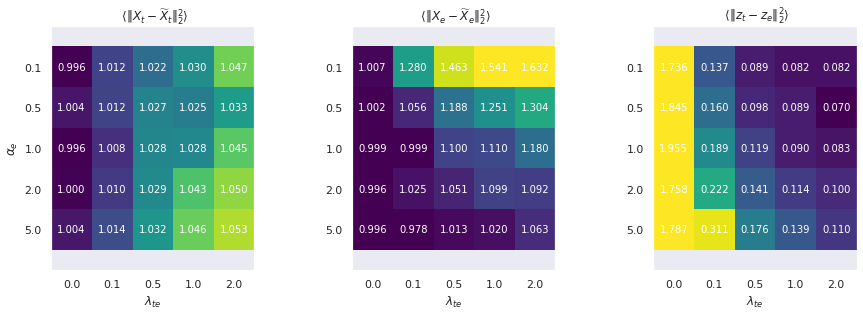

In [6]:
fig, ax = plt.subplots(1,3,figsize=(13,4.5))
plot_heatmap(ax=ax[0],M=T_recon_mean/np.mean(T_recon_mean[0,:]),Xarr=csTE_array,Yarr=aE_array,Xlabel=r'$\lambda_{te}$',Ylabel=r'$\alpha_{e}$',title=r' $ \langle \Vert X_{t} -  \widetilde{X}_{t} \Vert_2^2 \rangle $',c=(1.0,1.06))
plot_heatmap(ax=ax[1],M=E_recon_mean/np.mean(E_recon_mean[0,:]),Xarr=csTE_array,Yarr=aE_array,Xlabel=r'$\lambda_{te}$',Ylabel='',title=r' $ \langle \Vert X_{e} -  \widetilde{X}_{e} \Vert_2^2 \rangle $',c=(1.0,1.5))
plot_heatmap(ax=ax[2],M=TE_dist_mean,Xarr=csTE_array,Yarr=aE_array,Xlabel=r'$\lambda_{te}$',Ylabel='',title=r' $ \langle \Vert z_{t} -  z_{e} \Vert_2^2 \rangle $',c=(0.07,0.32))
plt.tight_layout()
fig.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2019/Hparam_search.png',dpi=300)

**Individual training curves**: Spot checks for over-fitting

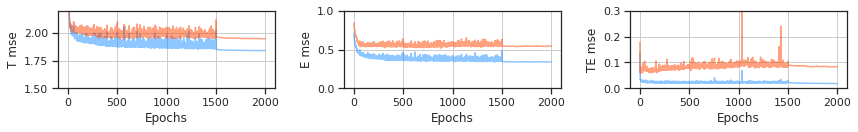

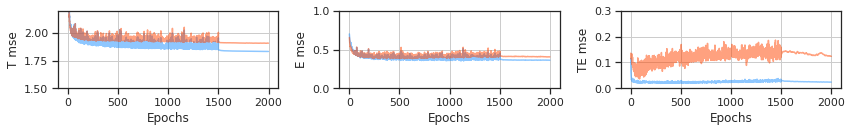

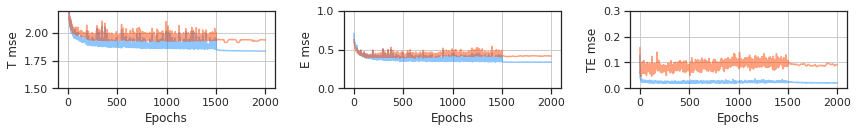

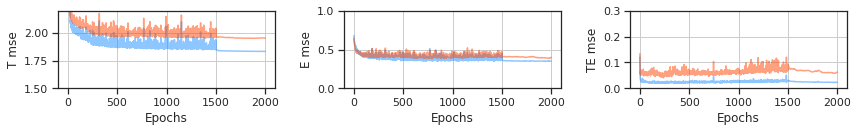

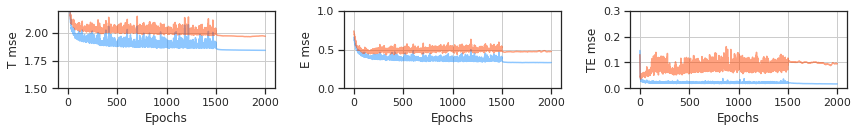

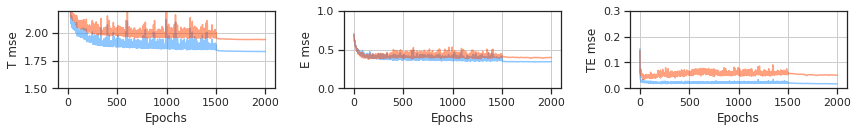

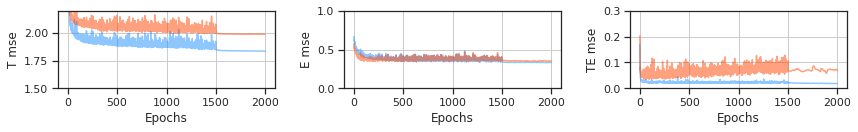

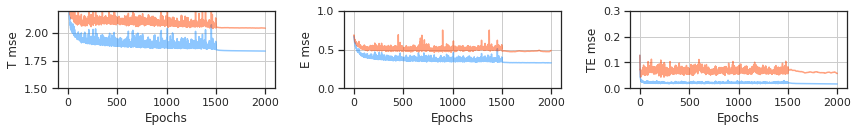

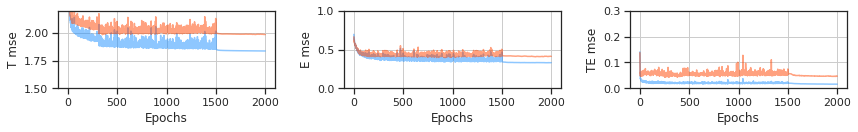

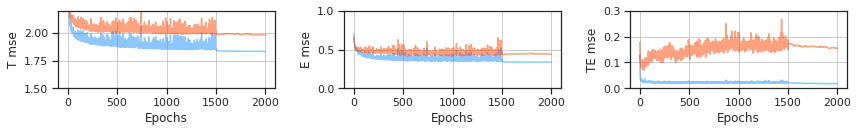

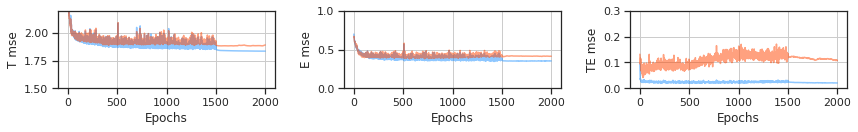

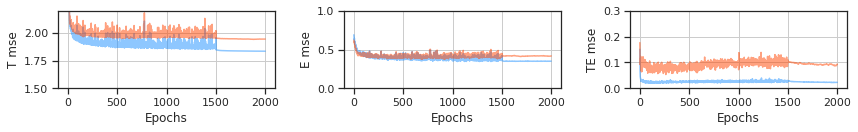

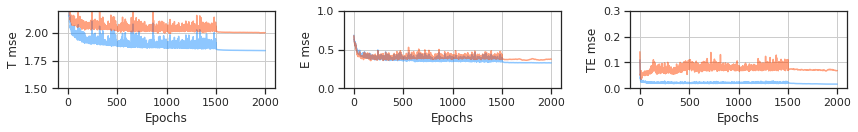

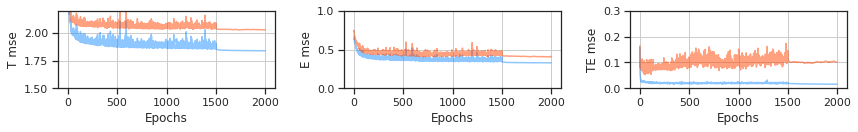

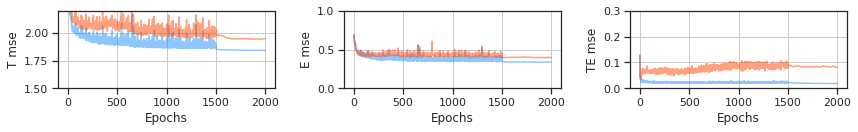

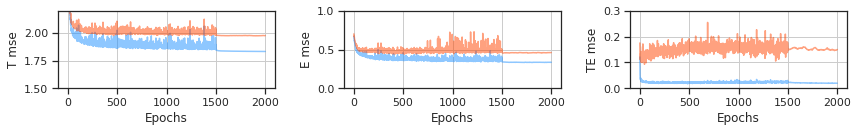

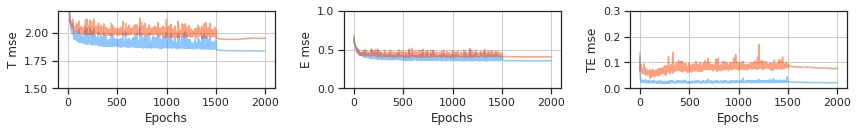

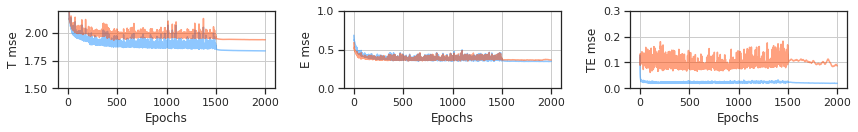

In [71]:
dir_pth['logs'] = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/logs/'
for cv in range(20):
    if cv not in [2,3]:
        D = pd.read_csv(dir_pth['logs']+'v3_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_cv_{:s}_ri_0.csv'.format(str(cv)))
        E = pd.read_csv(dir_pth['logs']+'v3_Edat_pcipfx_aT_1-0_aE_1-0_cs_1-0_ld_3_bs_200_se_500_ne_1500_cv_{:s}_ri_0_500_ft.csv'.format(str(cv)))
        E['train_epoch'] = E['train_epoch'] + D['train_epoch'].max()
        E['val_epoch'] = E['val_epoch'] + D['val_epoch'].max()
        D = D.append(E).reset_index(drop=True)

        fig,ax = plt.subplots(1,3,figsize=(12,2))
        plt.sca(ax[0])
        plt.plot(D['train_epoch'],D['train_mse_T'],'-',c='dodgerblue',alpha=0.5)
        plt.plot(D['val_epoch'],D['val_mse_T'],'-',c='orangered',alpha=0.5)
        ax[0].set_ylabel('T mse')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylim(1.5,2.2)

        plt.sca(ax[1])
        plt.plot(D['train_epoch'],D['train_mse_E'],'-',c='dodgerblue',alpha=0.5)
        plt.plot(D['val_epoch'],D['val_mse_E'],'-',c='orangered',alpha=0.5)
        ax[1].set_ylabel('E mse')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylim(0,1)

        plt.sca(ax[2])
        plt.plot(D['train_epoch'],D['train_mse_TE'],'-',c='dodgerblue',alpha=0.5)
        plt.plot(D['val_epoch'],D['val_mse_TE'],'-',c='orangered',alpha=0.5)
        ax[2].set_ylabel('TE mse')
        ax[2].set_xlabel('Epochs')
        ax[2].set_ylim(0,0.3)
    
    plt.tight_layout()

**Per feature reconstruction error**

In [59]:
raw_data_pth = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
O = sio.loadmat(raw_data_pth+'PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat',squeeze_me=True)

#Concatenated ephys pc + ipfx features
O['E_dat'] = np.concatenate([O['E_pc_scaled'],O['E_feature']],axis=1)
E_feature_list=np.concatenate([O['pc_name'],O['feature_name']]).tolist()

In [60]:
csTE = '2-0'
aE = '1-0'
n_cvsets = 20

dir_pth['result'] = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/'

X = np.empty(shape=(n_cvsets,O['E_dat'].shape[1]))
Y = np.empty(shape=(n_cvsets,O['E_dat'].shape[1]))
for cv in range(n_cvsets):
    D = sio.loadmat(dir_pth['result']+'v3_Edat_pcipfx_aT_1-0_aE_{:s}_cs_{:s}_ld_3_bs_200_se_500_ne_1500_cv_{:s}_ri_0500_ft-summary.mat'.format(aE,csTE,str(cv)),squeeze_me=True)
    X[cv,:] = np.nanmean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:]),axis=0)    
    Y[cv,:] = np.nanmean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE_from_XT'][D['val_ind'],:]),axis=0)    

In [47]:
plt.close('all')

In [36]:
%matplotlib inline

In [63]:
np.nanvar([0,1])

0.25

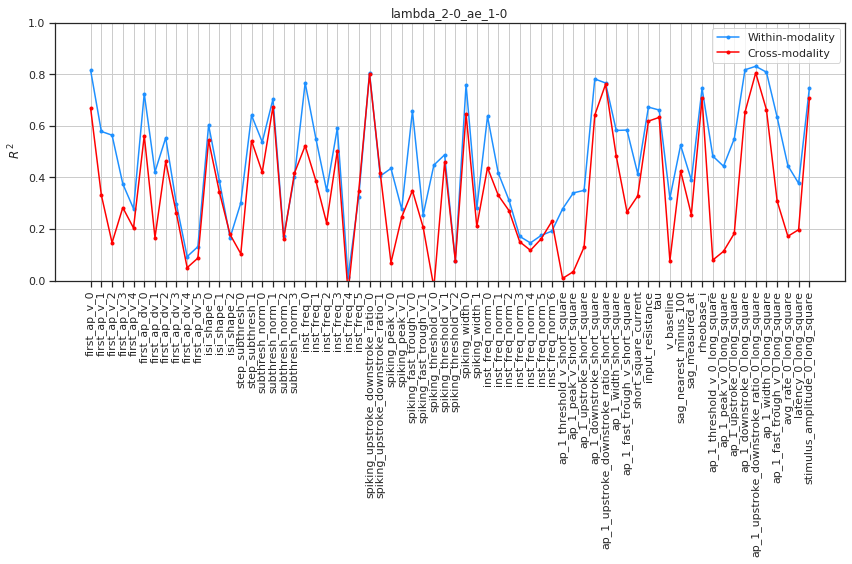

In [70]:
sns.set()
sns.set_style('ticks',{'axes.grid' : True}) 
cols = ['#0343df','#e50000']

xx = np.arange(0,X.shape[1],1)

#With modality reconstruction
yy=np.mean(X,axis=0)
err=np.std(X,axis=0)/np.sqrt(X.shape[0])

#Cross modal prediction
yy2=np.mean(Y,axis=0)
err2=np.std(Y,axis=0)/np.sqrt(Y.shape[0])

#baselines------------------------------
#With modality reconstruction
y2y=np.mean(X2,axis=0)
e2rr=np.std(X2,axis=0)/np.sqrt(X2.shape[0])

#Cross modal prediction
y2y2=np.mean(Y2,axis=0)
e2rr2=np.std(Y2,axis=0)/np.sqrt(Y2.shape[0])

fig = plt.figure(figsize=(12,8))
#plt.plot(np.arange(len(E_feature_list)),np.nanvar(O['E_dat'],axis=0),c='#000000',alpha = 0.2,label='Data variance')
plt.plot(np.arange(len(E_feature_list)),1 - yy/np.nanvar(O['E_dat'],axis=0),'.-',c='dodgerblue',alpha = 1,label='Within-modality')
plt.plot(np.arange(len(E_feature_list)),1 - yy2/np.nanvar(O['E_dat'],axis=0),'.-',c='red',alpha = 1,label='Cross-modality')
#plt.errorbar(x=xx,y=yy,yerr=err,c=cols[0],capsize=5,ls='-',marker='.',ms=5,label='Reconstruction from representation')
#plt.errorbar(x=xx,y=yy2,yerr=err2,c=cols[1],capsize=5,ls='-',marker='.',ms=5,label='Crossmodal reconstruction')
ax = plt.gca()
ax.set_xticks(np.arange(len(E_feature_list)))
ax.set_xticklabels(E_feature_list,rotation=90)
ax.set_ylabel(r' $ R^2 $')
ax.set_ylim(0,1)
plt.legend()
plt.title('lambda_'+str(csTE)+'_ae_'+str(aE))
plt.tight_layout()
#fig.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2019/E_recon_pc_ipfx.png',dpi=300)

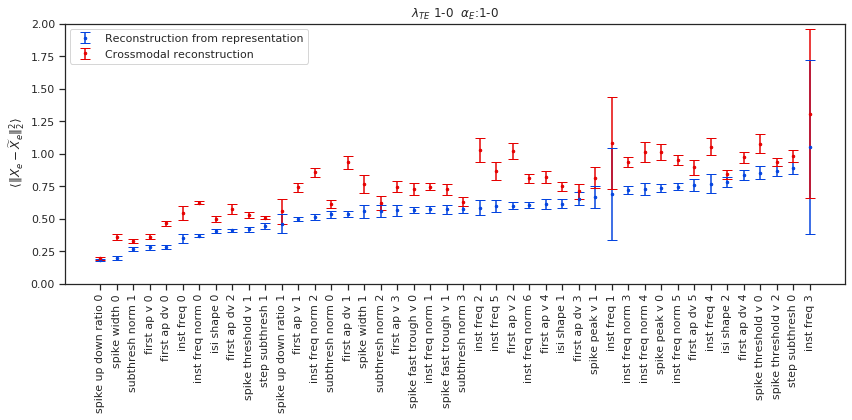

In [11]:
ind=np.argsort(yy)
fig = plt.figure(figsize=(12,6))
plt.errorbar(x=xx,y=yy[ind],yerr=err[ind],c=cols[0],capsize=5,ls='',marker='.',ms=5,label='Reconstruction from representation')
plt.errorbar(x=xx,y=yy2[ind],yerr=err2[ind],c=cols[1],capsize=5,ls='',marker='.',ms=5,label='Crossmodal reconstruction')
ax = plt.gca()
ax.set_xticks(np.arange(len(E_features_arr)))
ax.set_xticklabels(E_features_arr[ind],rotation=90)
ax.set_ylabel(r' $ \langle \Vert X_{e} - \widetilde{X}_{e} \Vert_2^2 \rangle $')
ax.set_ylim(0,2.0)
plt.legend()
plt.title(r'$\lambda_{TE}$ '+str(csTE)+'  '+r'$\alpha_{E}$:'+str(aE))
plt.tight_layout()
fig.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Epredsorted_lambda_'+str(csTE)+'_ae_'+str(aE)+'_v2_ft.png',dpi=300)

In [12]:
dir_pth = {}
dir_pth['result'] = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/'
dir_pth['logs'] = dir_pth['result']+'logs/'
dir_pth['checkpoints'] =dir_pth['result']+'checkpoints/'

aE = '1-0'

X = np.empty(shape=(9,E_features_arr.size))
Y = np.empty(shape=(9,E_features_arr.size))
Z = np.empty(shape=(9,E_features_arr.size))
for cv in range(9):
    csTE = '1-0'    
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    X[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)    
    
    csTE = '0-1'
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    Y[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)    
    
    csTE = '0-0'
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    Z[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)

In [36]:
cols = sns.color_palette("coolwarm", 3)

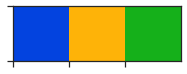

In [44]:

cols = sns.xkcd_palette(["blue", "amber", "green"])
sns.palplot(cols)
#sns.palplot(sns.color_palette(cols))

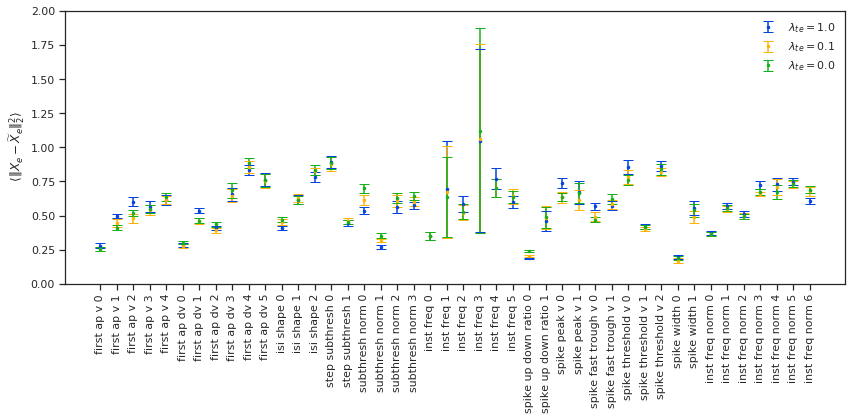

In [45]:
xx = np.arange(0,X.shape[1],1)

#Within modality reconstruction
yy=np.mean(X,axis=0)
err=np.std(X,axis=0)/np.sqrt(X.shape[0])

yy2=np.mean(Y,axis=0)
err2=np.std(Y,axis=0)/np.sqrt(Y.shape[0])

yy3=np.mean(Z,axis=0)
err3=np.std(Z,axis=0)/np.sqrt(Z.shape[0])

fig = plt.figure(figsize=(12,6))
sns.set()
sns.set_style('ticks',{'axes.grid' : False})

plt.errorbar(x=xx,y=yy,yerr=err,capsize=5,c=cols[0],ls='',marker='.',ms=5,label=r'$\lambda_{te}=1.0$')
plt.errorbar(x=xx,y=yy2,yerr=err2,capsize=5,c=cols[1],ls='',marker='.',ms=5,label=r'$\lambda_{te}=0.1$')
plt.errorbar(x=xx,y=yy3,yerr=err3,capsize=5,c=cols[2],ls='',marker='.',ms=5,label=r'$\lambda_{te}=0.0$')
ax = plt.gca()
ax.set_xticks(np.arange(len(E_features_list)))
ax.set_xticklabels(E_features_list,rotation=90)
ax.set_ylabel(r' $ \langle \Vert X_{e} -  \widetilde{X}_{e} \Vert_2^2 \rangle $')
ax.set_ylim(0,2.0)
plt.legend(edgecolor='None')
plt.tight_layout()
fig.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Epred_lambda_sweep_v2_ft.png',dpi=300)

**Effect of latent space dimensionality on electrophysiological reconstruction**

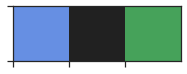

In [61]:

cols = sns.diverging_palette(255, 133, l=60, n=3, center="dark")
sns.palplot(cols)

In [62]:
dir_pth = {}
dir_pth['result'] = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/'
dir_pth['logs'] = dir_pth['result']+'logs/'
dir_pth['checkpoints'] =dir_pth['result']+'checkpoints/'

aE = '1-0'
csTE = '1-0'

X = np.empty(shape=(9,E_features_arr.size))
Y = np.empty(shape=(9,E_features_arr.size))
Z = np.empty(shape=(9,E_features_arr.size))
for cv in range(9):
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_2_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    X[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)    
    
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    Y[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)    
    
    D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_5_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)
    Z[cv,:] = np.mean(np.square(O['E_dat'][D['val_ind'],:] - D['XrE'][D['val_ind'],:-1]),axis=0)

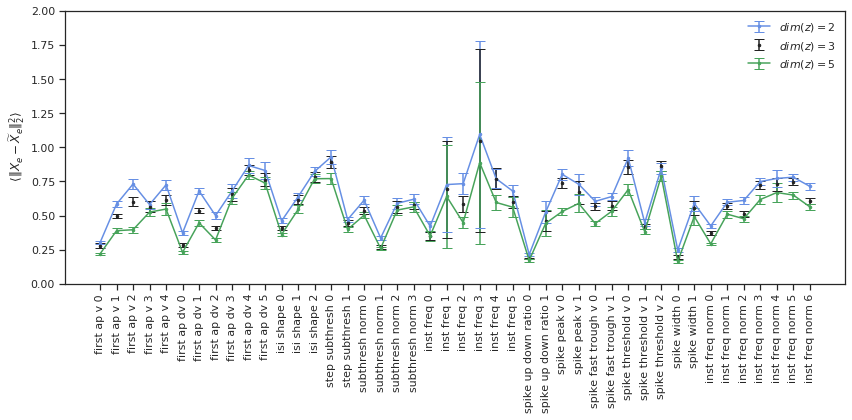

In [63]:
xx = np.arange(0,X.shape[1],1)

#Within modality reconstruction
yy=np.mean(X,axis=0)
err=np.std(X,axis=0)/np.sqrt(X.shape[0])

yy2=np.mean(Y,axis=0)
err2=np.std(Y,axis=0)/np.sqrt(Y.shape[0])

yy3=np.mean(Z,axis=0)
err3=np.std(Z,axis=0)/np.sqrt(Z.shape[0])

fig = plt.figure(figsize=(12,6))
sns.set()
sns.set_style('ticks',{'axes.grid' : False})

plt.errorbar(x=xx,y=yy,yerr=err,capsize=5,c=cols[0],ls='-',marker='.',ms=5,label=r'$dim(z)=2$')
plt.errorbar(x=xx,y=yy2,yerr=err2,capsize=5,c=cols[1],ls='',marker='.',ms=5,label=r'$dim(z)=3$')
plt.errorbar(x=xx,y=yy3,yerr=err3,capsize=5,c=cols[2],ls='-',marker='.',ms=5,label=r'$dim(z)=5$')
ax = plt.gca()
ax.set_xticks(np.arange(len(E_features_list)))
ax.set_xticklabels(E_features_list,rotation=90)
ax.set_ylabel(r' $ \langle \Vert X_{e} -  \widetilde{X}_{e} \Vert_2^2 \rangle $')
ax.set_ylim(0,2.0)
plt.legend(edgecolor='None')
plt.tight_layout()
fig.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/Epred_dim_sweep_v2_ft.png',dpi=300)

**Representations**

In [1]:
%matplotlib qt5

In [2]:
import os
import fnmatch
import pprint

import numpy as np
import scipy.io as sio
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from IPython.display import HTML

def scatter3(X,col,xlims=(3,3),ylims=(3,3),zlims=(3,3)):
    sns.set_style("whitegrid")
    plt.ion()
    fig = plt.figure(figsize=(4,4))    
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(X[:,0], X[:,1], X[:,2],s=1,alpha=1,c=col)

    ax.set_xticks([])
    ax.set_zticks([])
    ax.set_yticks([])
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    
    ax.set_xlim(xlims[0],xlims[1])
    ax.set_ylim(ylims[0],ylims[1])
    ax.set_zlim(zlims[0],zlims[1])

    plt.axis('on')
    ax.set_frame_on(False)
    plt.tight_layout()
    return ax,sc

In [3]:
dir_pth={}
raw_data_pth = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
dir_pth['result'] = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/result/Patchseq_NM_2019/'
dir_pth['representations'] = '/home/rohan/Remote-AI/dat/result/TE_aug_decoders/'
csTE='1-0'
aE = '1-0'
cv=1

#Full data matrices
O = sio.loadmat(raw_data_pth+'PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat',squeeze_me=True)
                                           
D = sio.loadmat(dir_pth['representations']+'v3_Edat_pcipfx_aT_1-0_aE_{:s}_cs_{:s}_ld_3_bs_200_se_500_ne_1500_cv_0_ri_0500_ft-summary.mat'.format(aE,csTE),squeeze_me=True)

xlims=(-2.5,1.2)
ylims=(-1.1,3)
zlims=(-1.1,3)
padval=-210
fontsizeval=13

In [5]:
ax,sc = scatter3(D['zT'],O['cluster_color'],xlims,ylims,zlims)
ax.set_title(r'$z_t$, $\lambda_{te}$='+csTE.replace('-','.'),pad=padval,fontsize=fontsizeval)
ax.view_init(elev=-31.0, azim=-47)
fig = plt.gcf()

def update(i):
    ax.view_init(elev=10., azim=i)
    fig.canvas.draw()
    fig.canvas.flush_events()
    return

#plt.savefig('/Users/fruity/Desktop/zT_alphaE_1_lambda_1.png',dpi=300)
#anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)
#HTML(anim.to_html5_video())

In [ ]:
anim.save('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2019/representation_T_z_'+csTE+'.gif', dpi=160, writer='imagemagick')

In [8]:
ax,sc = scatter3(D['zT'],O['cluster_color'],xlims,ylims,zlims)
ax.set_title(r'$z_{me}$, $\lambda_{te}$='+csTE.replace('-','.'),pad=padval,fontsize=fontsizeval)
ax.view_init(elev=-31.0, azim=-47)
fig = plt.gcf()

def update(i):
    ax.view_init(elev=10., azim=i)
    fig.canvas.draw()
    fig.canvas.flush_events()
    return
#plt.savefig('/Users/fruity/Desktop/zE_alphaE_1_lambda_1.png',dpi=300)
# anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)
# HTML(anim.to_html5_video())

In [ ]:
anim.save('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2019/representation_E_z_'+csTE+'.gif', dpi=160, writer='imagemagick')